scan wa page
--> request page's html
--> save the necessary part of the page into a txt file
--> scan through job links on that page
--> get the nth link -> save to a list -> request -> save file -> process -> add to df
--> k00th link -> save to csv



Cạnh tranh gần nhất:

https://pantio.vn/

https://ivymoda.com/

https://elise.vn/

(1 - 3 năm)


https://sixdo.vn/

(lâu dài)


In [293]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
import os
import requests
import time
from datetime import datetime
from IPython.display import clear_output
import requests
import os
from bs4 import BeautifulSoup
import pandas as pd
import re
from urllib.parse import urlparse, unquote
import json
import csv
# os.environ['PATH'] += r"E:\Installers\chromedriver_win32\chromedriver.exe"

In [294]:
path = os.getcwd()
path

'e:\\COLLEGE\\PROJECT\\Thay Nhan\\INTERN\\Crawling\\crawling_code'

# Get numbered pages' url

In [295]:
def make_num_pages_list(main_site_url, url_format, start_page, end_page):
    all_pages_list = []
    all_pages_list += [main_site_url]
    
    for i in range(start_page, end_page+1):
        url = url_format.format(i)
        all_pages_list.append(url)
    
    return  all_pages_list
# all_pages_list = make_num_pages_list(main_site_url = 'https://elise.vn/thoi-trang-nu', 
#                                      url_format='https://elise.vn/thoi-trang-nu?pnpmls={}', 
#                                      start_page = 2, 
#                                      end_page = 10)
   
# for num_page in all_pages_list:
#     print(num_page)

# Tạo file csv database tổng nếu chưa tồn tại


In [296]:
def create_db_csv(data_folder, domain):
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    csv_file_path = os.path.join(data_folder, domain, f"list_info_all.csv")

    if not os.path.exists(csv_file_path):
        with open(csv_file_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['general_id', 'product_id', 'sku', 'url', 'product_name', 'price', 'size', 'color', 'description'])

    return csv_file_path
# # Example usage
# data_folder = r"E:\COLLEGE\PROJECT\Thay Nhan\INTERN\Crawling\data"
# domain = domain

# csv_file_path = create_db_csv(data_folder, domain)
# print("CSV file created at:", csv_file_path)


# Lưu HTML của numbered pages

In [297]:
import requests
from bs4 import BeautifulSoup
import re
import os
from urllib.parse import urlparse
from datetime import datetime

def saving_numbered_pages(url, domain, attempt_folder_path):
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    
    if domain == 'elise':
        if '=' not in url:
            pagenum = 'page1'
        else:
            # FOR ELISE
            pagenum = url.split('=')[1]
            pagenum = f'page{pagenum}'
    else:
        pagenum = 'not_elise_pagenum'
        
    current_datetime = datetime.now()
    list_view_folder = os.path.join(attempt_folder_path, 'list view')
    os.makedirs(list_view_folder, exist_ok=True)  
    
    i = 1
    while True:
        file_id = f"{i:05d}"
        file_name = f"[{current_datetime.strftime('%Y%m%d %H%M%S')}]_{domain}_{file_id}_{pagenum}.txt"
        file_path = os.path.join(list_view_folder, file_name)
        if not os.path.exists(file_path):
            break
        i += 1
    
    # FOR ELISE
    if domain == 'elise':
        needed_div = soup.find('div', class_='info-content-wrapper')
        if needed_div:
            div_content = needed_div.prettify()
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(div_content)
            
    return file_path

# Lưu HTML của detail

In [298]:
import requests
from bs4 import BeautifulSoup
import re
import os
from urllib.parse import urlparse
from datetime import datetime

def saving_detail_html(soup, domain, detail_folder_path):
    file_name = f"html.txt"
    file_path = os.path.join(detail_folder_path, file_name)

    
    # FOR ELISE
    if domain == 'elise':
        needed_div = soup.find('div', class_='main')
        if needed_div:
            div_content = needed_div.prettify()
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(div_content)
            
    return file_path

# Lấy path attempt folder

In [299]:
## Tính lần cào
def get_attempt(current_datetime):
    hour = current_datetime.strftime("%H") 
    minute = current_datetime.strftime("%M")

    attempt = f'attempt_at_{hour}{minute}'
    return attempt

def create_attempt_folder(data_folder, domain_folder, current_datetime, attempt):
    
    # Create subfolders based on year, month, and day
    page_folder = os.path.join(data_folder, domain_folder)
    year_folder = os.path.join(page_folder, str(current_datetime.year))
    month_folder = os.path.join(year_folder, str(current_datetime.month))
    day_folder = os.path.join(month_folder, str(current_datetime.day))
    # lần cào
    attempt_folder = os.path.join(day_folder, attempt)
    
    if not os.path.exists(attempt_folder):
        os.makedirs(attempt_folder)
    
    return attempt_folder

# Lưu tracking_file

In [300]:
def save_tracking_file(attempt_folder_path, tracking_df, tracking_df_name):
    file_path = os.path.join(attempt_folder_path, f'{tracking_df_name}.csv')
    tracking_df.to_csv(file_path, index=False)
    
    return file_path

# Xác định Detailview cần cào từ Listview

In [301]:
def add_dup_ids(list_info_attempt, list_info_all):
    # Lấy những ids trùng trong list_info_attempt và list_info_all
    current_ids = list_info_attempt['general_id']
    available_ids = list_info_all['general_id']
    overlap_ids = set(current_ids) & set(available_ids)

    # Giữ những dòng có id trùng nhau trong list_info_attempt và list_info_all để check khác nhau
    filtered_attempt_df = list_info_attempt[list_info_attempt['general_id'].isin(overlap_ids)]
    filtered_all_df = list_info_all[list_info_all['general_id'].isin(overlap_ids)]

    # Có thể có TH trong list_info_all id đã bị trùng (do cào thêm vào)
    # Chỉ lấy dòng chứa id trùng gần nhất trong list_info_all để đối chiếu với list_info_attempt
    filtered_all_df_recent_ids = filtered_all_df.drop_duplicates(subset='general_id', keep='last')

    # Tìm những dòng khác trong list_info_attempt
    # Chỉ cần khác một attribute đã tính là khác
    def check_for_differences(row):
        return any(row[column + '_attempt'] != row[column + '_all'] for column in filtered_attempt_df.columns if column != 'general_id')

    merged_df = filtered_attempt_df.merge(filtered_all_df_recent_ids, on='general_id', suffixes=('_attempt', '_all'))
    different_info_ids = merged_df.apply(check_for_differences, axis=1)

    # Trích xuất lấy phần những dòng khác với list_info_all trong list_info_attempt
    different_info_ids = merged_df[different_info_ids]['general_id']
    list_info_add = list_info_attempt[list_info_attempt['general_id'].isin(different_info_ids)]
    return(list_info_add)


def add_new_ids(list_info_attempt, list_info_all):
    current_ids = list_info_attempt['general_id']
    available_ids = list_info_all['general_id']

    new_ids = set(current_ids) - set(available_ids)
    list_info_add = list_info_attempt[list_info_attempt['general_id'].isin(new_ids)]
    
    return list_info_add

def create_list_info_add(list_info_attempt, list_info_all):
    new_ids_df = add_new_ids(list_info_attempt = list_info_attempt,
                            list_info_all = list_info_all)    

    dup_ids_df = add_dup_ids(list_info_attempt = list_info_attempt,
                            list_info_all = list_info_all)
    
    list_info_add = pd.concat([new_ids_df,dup_ids_df], axis=0)
    return list_info_add

# Lọc Detailview cần cào bổ sung

In [302]:
def get_ids_to_crawl_detail(attempt_folder_path):
    ids_to_crawl_detail = []
    # Tạo list đường dẫn đến các json files
    json_files = []
    for root, dirs, files in os.walk(attempt_folder_path):
        for file in files:
            if file.endswith('.json'):
                if 'list view' not in root:
                    json_files.append(os.path.join(root, file))
                
    ids_to_crawl_detail = list(list_info_add['general_id'])
    
    if len(json_files) == 0:
        return ids_to_crawl_detail
        
    else:
        # Gộp các json files thành df            
        dataframes = []
        
        for file_path in json_files:
            if os.path.getsize(file_path) == 0:
                continue
            
            else:
                detail_available_df = pd.read_json(file_path, encoding='utf-8')
                dataframes.append(detail_available_df)
                
        if dataframes:
            detail_available_df = pd.concat(dataframes, ignore_index=True)
            ids_to_crawl_detail = list(list_info_add['general_id'][~list_info_add['general_id'].isin(list(detail_available_df['general_id']))])  
            
    return ids_to_crawl_detail

# Tạo list_info_done

In [303]:
def create_list_info_done(attempt_folder_path):
    list_info_done = []
    # Tạo list đường dẫn đến các json files
    json_files = []
    for root, dirs, files in os.walk(attempt_folder_path):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
                

    if len(json_files) == 0:
        list_info_done = []
        return None, None
        
    else:
        # Gộp các json files thành df            
        dataframes = []
        
        for file_path in json_files:
            if os.path.getsize(file_path) == 0:
                pass
            
            else:
                detail_available_df = pd.read_json(file_path, encoding='utf-8')
                dataframes.append(detail_available_df)
                
        if dataframes:
            detail_available_df = pd.concat(dataframes, ignore_index=True)
            list_info_done = list_info_add[list_info_add['general_id'].isin(list(detail_available_df['general_id']))]
            list_info_done_path = save_tracking_file(attempt_folder_path, list_info_done, 'list_info_done')    
            
            return list_info_done, list_info_done_path

# Gộp detail_info_attempt

In [304]:
def create_detail_info_attempt(attempt_folder_path):
    ids_to_crawl_detail = []
    # Tạo list đường dẫn đến các json files
    json_files = []
    for root, dirs, files in os.walk(attempt_folder_path):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
                

    if len(json_files) == 0:
        return None, None
        
    else:
        # Gộp các json files thành df            
        dataframes = []
        detail_info_attempt = None
        
        for file_path in json_files:
            if os.path.getsize(file_path) == 0:
                pass
            
            else:
                detail_info_attempt = pd.read_json(file_path, encoding='utf-8')
                dataframes.append(detail_info_attempt)
                
        if dataframes:
            detail_info_attempt = pd.concat(dataframes, ignore_index=True)
            
    detail_info_attempt_path = save_tracking_file(attempt_folder_path, detail_info_attempt, 'detail_info_attempt')
    
    return detail_info_attempt, detail_info_attempt_path

# Tạo thư mục cho từng detail view

In [305]:
import requests
from bs4 import BeautifulSoup
import re
import os
from urllib.parse import urlparse
from datetime import datetime

def get_next_subfolder(detail_view_folder, part_folder_size):
    subfolder_id = part_folder_size  
    while True:
        subfolder_path = os.path.join(detail_view_folder, str(subfolder_id))
        if not os.path.exists(subfolder_path) or len(os.listdir(subfolder_path)) < part_folder_size:
            return subfolder_path
        subfolder_id += part_folder_size

def create_detail_folder(attempt_folder_path, product_id, product_name, part_folder_size):
    # Get the current date and time
    current_datetime = datetime.now()

    detail_view_folder = os.path.join(attempt_folder_path, 'detail view')
    
    part_folder = get_next_subfolder(detail_view_folder, part_folder_size)
    os.makedirs(part_folder, exist_ok=True)  
    
    
    i = 1
    while True:
        file_id = f"{i:05d}"
        folder_name = f"[{current_datetime.strftime('%Y%m%d %H%M%S')}]_{product_id}_{file_id}_{product_name}"
        folder_path = os.path.join(part_folder, folder_name)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            return folder_path
        i += 1

## Get all products' links

In [306]:
import re
def get_links(pagination_pages):
    wanted_links = []
    with open(pagination_pages, 'r') as f:
#         lines = f.readlines()[:2]  # Read only the first two lines to test
#         for line in lines:
        for line in f:
            page_url = line.strip()
            response = requests.get(page_url)
            html_content = response.content.decode()
            soup = BeautifulSoup(html_content, "html5lib")

            # FOR LATINA.VN
            if 'latina' in page_url:
                product_names = soup.find_all('div', class_='product-name')

                for product in product_names:
                    link = product.find('a', class_='link')['href']
                    hyperlink = "https://latina.vn" + link
                    wanted_links += [hyperlink]
            elif 'elise' in page_url:
                product
                
            print(f'Finished: {line}.')
            clear_output(wait=True)
    
    match = re.search(r'numbered_pages_(.*?)\.txt', pagination_pages)
    if match:
        domain = match.group(1)
        file_name = f'wanted_links_{domain}.txt'
        
    file_path = os.path.join(os.path.dirname(path), 'crawling_materials')
    file_wanted_links = os.path.join(file_path, file_name)
    
    with open(file_wanted_links, 'w', encoding='utf-8') as f:
        for link in wanted_links:
            f.write(f'{link}\n')

    return file_wanted_links

In [307]:
def saving_detail_file(url, data_folder):
    html = requests.get(url).text
    soup = BeautifulSoup(html, "html.parser")
    
    # FOR LATINA
    if 'latina' in url:
        needed_div = soup.find('section', class_='product detail-main')
    # FOR CAREER LINK
    if 'careerlink' in url:
        needed_div = soup.find('div', class_='card border-0 font-nunitosans px-4')
        
    # FOR VNWORKS
    if 'vietnamworks' in url:
        needed_div = soup.find('div', class_='page-foreground')
        
    # FOR HOTEL JOB
    if 'hotel' in url:
        needed_div = soup.find('section', class_='py-lg-4')
        
    if needed_div:
        div_content = needed_div.prettify()
        file_path = file_naming(url, data_folder)
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(div_content)
        return file_path

In [308]:
import os
from urllib.parse import urlparse, unquote
from datetime import datetime


def save_csv_file(df, batch_number, domain, data_folder=r"E:\test"):
    
    current_datetime = datetime.now()
    
    # Create subfolders based on year, month, and day
    year_folder = os.path.join(data_folder, str(current_datetime.year))
    month_folder = os.path.join(year_folder, str(current_datetime.month))
    day_folder = os.path.join(month_folder, str(current_datetime.day))
    csv_folder = os.path.join(day_folder, domain)
    
    
    os.makedirs(csv_folder, exist_ok=True)  

    
    i = 1
    while True:
        file_id = f"{i:05d}"
        file_name = f"[{current_datetime.strftime('%Y%m%d %H%M%S')}]_{file_id}_batch{batch_number}.csv"
        file_path = os.path.join(csv_folder, file_name)
        if not os.path.exists(file_path):
            df.to_csv(file_path, index=False)
            return
        i += 1

In [309]:
def extract_and_save_ids(url, output_file='ids.txt'):
    id = None

    if 'latina' in url:
        id = 'latin_' + url.split('-')[-1]
    elif 'careerlink' in url:
        id = 'careerlink_' + url.split('?')[0].split('/')[-1]
    elif 'vietnamworks' in url:
        id = 'vnworks_' + url.split('&')[-2].split('=')[-1]
    elif 'hotel' in url:
        id = 'hoteljob_' + url.split('/')[-1].split('-')[0]

    if id is not None:
        try:
            with open(output_file, 'r') as file:
                existing_ids = [line.strip() for line in file]
                if id in existing_ids:
                    return False
                else:
                    with open(output_file, 'a') as file:
                        file.write(id + '\n')
                        return True
        except FileNotFoundError:
            pass



# Cào

## LIST VIEW

In [310]:
def crawl_list_view_elise(url, domain):
    product_info_list = []
    html_content = requests.get(url).text
    soup = BeautifulSoup(html_content, "html5lib")
    
    all_items = soup.find_all('div', class_='item-content-wrapper')
    
    for item in all_items:
    # Product id
        product_id = item.find('div', class_='price-box')['data-product-id']
        
    # General ID
        general_id = f'{domain}_{product_id}'
        
    # Product SKU
        product_url = item.find('a', class_='product-item-link')['href']
        product_sku = product_url[-20:].replace('.html', '')
        
    # Product name
        product_name = item.find('h5', class_='product-item-name').text.strip()
        
    # Product price
        product_price = item.find('span', class_='price-wrapper').text.strip().replace('\xa0', ' ')
        
        
    # Product images
        images = item.find_all('img', class_='product-image-photo')
        img_dict = {}

        image_order = 1
        for img in images:   
            img_name = img['alt']
            img_order_name = f'{image_order:03d}_{img_name}'
            
            img_src = img['data-src']
            img_dict[img_order_name] = img_src
                    
            image_order += 1
        
        
        product_info = {
        'general_id': general_id,
        'product_id': product_id,
        'sku': product_sku,
        'url': product_url,
        'product_name': product_name,
        'price': product_price,
        'image_list': img_dict
        }
        
        product_info_list.append(product_info)
        
    product_info_list_df = pd.DataFrame(product_info_list)
    return product_info_list_df
        

# crawl_list_view_elise(url='https://elise.vn/thoi-trang-nu?pnpmls=2', domain='elise')

## DETAIL VIEW

In [311]:
def crawl_detail_view_elise(soup, domain):
    
    # Product ID
    product_id = soup.find('div', class_='price-box')['data-product-id'].strip()
                
    # General ID
    general_id = f'{domain}_{product_id}'
        
    # SKU
    sku = soup.find('span', itemprop='sku').text.strip()

    # Name
    product_name = soup.find('h1', class_='product-name').text.strip()

    # Price
    price = soup.find('span', class_='price-wrapper').text.strip().replace('\xa0', ' ')

    # Size
    text_containing_sizes = soup.find('div', class_='product-options-wrapper').text
    sizes = re.findall(r'"label":"([A-Z]+)","products":\["\d+"\]},', text_containing_sizes)

    # Colors
    color = None

    # Description
    description = None
    
    # Images
    gallery = soup.find('div', class_='gallery-list')
    if gallery:
        images = gallery.find_all('img', class_='img-responsive')
    else:
        images = soup.find_all('img', class_='img-responsive')
    img_dict = {}

    image_order = 1
    for img in images:   
        img_name = img['alt']
        img_order_name = f'{image_order:03d}_{img_name}'
        
        img_src = img['src']
        img_dict[img_order_name] = img_src
                
        image_order += 1

    product_data = {
        "product_id": product_id,
        "general_id": general_id,
        "sku": sku,
        "product_name": product_name,
        "price": price,
        "size": sizes,
        "color": color,
        "description": description,
        'image_list': img_dict
    }

    product_data_df = pd.DataFrame([product_data])
    return product_data_df


## Lưu ảnh

In [312]:
from PIL import Image
def save_images(img_dict, folder_path):
    for img_name, img_src in img_dict.items():
        request_img = Image.open(requests.get(img_src, stream=True).raw)
        
        img_file_path = os.path.join(folder_path, f'{img_name}.jpg')
        request_img.save(img_file_path)

## Lưu json

In [313]:

from IPython.display import clear_output

def crawl_json_images_html(items_to_crawl):
    progress_count = 1
    for index, row in items_to_crawl.iterrows():
        url = row['url']
        product_id = row['product_id']
        product_name = row['product_name']
        
        
        
        # Folder to the detail
        detail_folder_path = create_detail_folder(attempt_folder_path, product_id, product_name, part_folder_size)
        
        # Get the detail df
        html = requests.get(url).text
        soup = BeautifulSoup(html, "html5lib")
        
        item_df = crawl_detail_view_elise(soup, domain)
        
                
        # Save to json_file
        json_file_path = os.path.join(detail_folder_path, 'data.json')
        with open(json_file_path, 'w', encoding='utf-8') as json_file:
            item_df.to_json(json_file, orient='records', force_ascii=False, indent=4)


        # Save images
        img_dict = item_df['image_list'].iloc[0]
        save_images(img_dict = img_dict, folder_path = detail_folder_path)
        
        
        # Save html
        saving_detail_html(soup, domain, detail_folder_path = detail_folder_path)

        
        
        
        # Print progress
        progress = progress_count / len(items_to_crawl) * 100
        progress_count += 1
        clear_output(wait=True)
        print(f"Progress: {progress:.2f}%")

In [314]:
url = 'https://elise.vn/ff2308012tlwoor.html'
html = requests.get(url).text
soup = BeautifulSoup(html, "html5lib")
soup.find('div', class_='product-options-wrapper').text

'\n    \n        \n\n\n    {\n        "[data-role=swatch-options]": {\n            "Magento_Swatches/js/swatch-renderer": {\n                "jsonConfig": {"attributes":{"178":{"id":"178","code":"size","label":"K\\u00edch c\\u1ee1","options":[{"id":"5431","label":"S","products":["56249"]},{"id":"5432","label":"M","products":["56250"]},{"id":"5434","label":"L","products":["56251"]},{"id":"5433","label":"XL","products":["56252"]}],"position":"0","type":""}},"template":"<%- data.price %>\\u00a0VND","currencyFormat":"%s\\u00a0VND","optionPrices":{"56249":{"oldPrice":{"amount":1098000},"basePrice":{"amount":1098000},"finalPrice":{"amount":1098000},"tierPrices":[],"msrpPrice":{"amount":null}},"56250":{"oldPrice":{"amount":1098000},"basePrice":{"amount":1098000},"finalPrice":{"amount":1098000},"tierPrices":[],"msrpPrice":{"amount":null}},"56251":{"oldPrice":{"amount":1098000},"basePrice":{"amount":1098000},"finalPrice":{"amount":1098000},"tierPrices":[],"msrpPrice":{"amount":null}},"56252":{"

In [315]:
soup.find('div', class_='swatch-option')

In [316]:
print(datetime.now())

2024-03-05 09:09:39.573669


# Tạo list_info_attempt

In [317]:
def create_list_info_attempt_html_json(all_pages_list, domain, attempt_folder_path):
    list_info_attempt = pd.DataFrame()  # Initialize an empty DataFrame
    
    # Cho tính progress
    overall_sum = len(all_pages_list)
    overall_count = 1

    # Scan qua các dòng link đến từng trang đánh số
    for page_url in all_pages_list:
        ## LƯU HTML của từng trang đánh số
        numbered_page_path = saving_numbered_pages(url=page_url, domain=domain, attempt_folder_path=attempt_folder_path)
        
        ## CÀO LIST
        product_info = crawl_list_view_elise(url=page_url, domain=domain)
        
        # Append the DataFrame returned by crawl_list_view_elise to list_info_attempt
        list_info_attempt = list_info_attempt.append(product_info, ignore_index=True)
        
        
        # LƯU JSON CHO TỪNG TRANG ĐÁNH SỐ
        list_view_folder = os.path.join(attempt_folder_path, 'list view')
        json_file_path = os.path.join(list_view_folder, f'page_{overall_count}.json')
        with open(json_file_path, 'w', encoding='utf-8') as json_file:
            product_info.to_json(json_file, orient='records', force_ascii=False, indent=4)
        
        ## TIẾN ĐỘ CHUNG
        overall_progress = round((overall_count / overall_sum) * 100, 2)
        print(f'Overall progress: {overall_progress}%')

        ## TIẾN ĐỘ CHUNG        
        overall_count += 1
        clear_output(wait=True)
        
        # if len(main_database) == 0:
        #     df = pd.DataFrame(attempt_data)
        #     df.to_csv(main_database_path, mode='a', index=False, header=False)

    return list_info_attempt


# Main

## Beginning

In [328]:
main_site_url = 'https://elise.vn/thoi-trang-nu'
if 'elise' in main_site_url:
    all_pages_list = make_num_pages_list(main_site_url = 'https://elise.vn/thoi-trang-nu', 
                                     url_format='https://elise.vn/thoi-trang-nu?pnpmls={}', 
                                     start_page = 2, 
                                     end_page = 3)
    domain = urlparse(main_site_url).netloc.split('.')[0]
    

    
# Folder chứa data
data_folder = r'E:\COLLEGE\PROJECT\Thay Nhan\INTERN\Crawling\data'
# Folder cho website
domain_folder = os.path.join(data_folder, domain)
if not os.path.exists(domain_folder):
    os.makedirs(domain_folder)

part_folder_size = 300

# Cào list view
## Tạo list_info_attempt
## Lưu json, html cho từng trang đánh số

In [329]:
current_datetime = datetime.now()
attempt = get_attempt(current_datetime)
attempt_folder_path = create_attempt_folder(data_folder, domain_folder, current_datetime, attempt)

list_info_attempt = create_list_info_attempt_html_json(all_pages_list, domain, attempt_folder_path)

Overall progress: 100.0%


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16456\2100933006.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  list_info_attempt = list_info_attempt.append(product_info, ignore_index=True)


In [330]:
list_info_attempt

,general_id,product_id,sku,url,product_name,price,image_list
0,elise_56399,56399,ff2309062bklabk,https://elise.vn/ff2309062bklabk.html,JUPE LƯỚI LEN ĐEN KẺ Ô XẺ BÊN,1.098.000 VND,{'001_JUPE LƯỚI LEN ĐEN KẺ Ô XẺ BÊN': 'https:/...
1,elise_56394,56394,ff2306187tlwobk,https://elise.vn/ff2306187tlwobk.html,SM ĐEN CỔ ĐỨC NẮP TÚI,1.098.000 VND,{'001_SM ĐEN CỔ ĐỨC NẮP TÚI': 'https://elise.v...
2,elise_56389,56389,ff2309033bpdege,https://elise.vn/ff2309033bpdege.html,QUẦN JEANS XANH MATCHA ỐNG SUÔNG,998.000 VND,{'001_QUẦN JEANS XANH MATCHA ỐNG SUÔNG': 'http...
3,elise_56384,56384,ff2311088tvlacr,https://elise.vn/ff2311088tvlacr.html,GILE REN HOA KEM TÚI ỐP,1.298.000 VND,{'001_GILE REN HOA KEM TÚI ỐP': 'https://elise...
4,elise_56379,56379,fs2311092bkwokk,https://elise.vn/fs2311092bkwokk.html,CHÂN VÁY KAKI BE XÒE BOM GẤU,1.298.000 VND,{'001_CHÂN VÁY KAKI BE XÒE BOM GẤU': 'https://...
...,...,...,...,...,...,...,...
167,elise_52466,52466,fw2306366bpdebl,https://elise.vn/fw2306366bpdebl.html,QUẦN JEANS XANH ỐNG LOE GẤU TO,1.198.000 VND,{'001_QUẦN JEANS XANH ỐNG LOE GẤU TO': 'https:...
168,elise_52356,52356,fs2303250bkwocr,https://elise.vn/fs2303250bkwocr.html,JUPE KEM XẾP LY,1.298.000 VND,{'001_JUPE KEM XẾP LY': 'https://elise.vn/medi...
169,elise_52331,52331,fs2305028tswowh,https://elise.vn/fs2305028tswowh.html,SM CÁT NHĂN TRẮNG BẤU MÍ PHỐI REN PK,1.198.000 VND,{'001_SM CÁT NHĂN TRẮNG BẤU MÍ PHỐI REN PK': '...
170,elise_52286,52286,fs2306050bkwobd,https://elise.vn/fs2306050bkwobd.html,JUPE BÚT CHÌ ĐỎ ĐÔ CẠP HOA,1.198.000 VND,{'001_JUPE BÚT CHÌ ĐỎ ĐÔ CẠP HOA': 'https://el...


# Xác định Detailview cần cào từ Listview

## Lọc mới, khác --> list_info_add

Lỗi khác kiểu dữ liệu
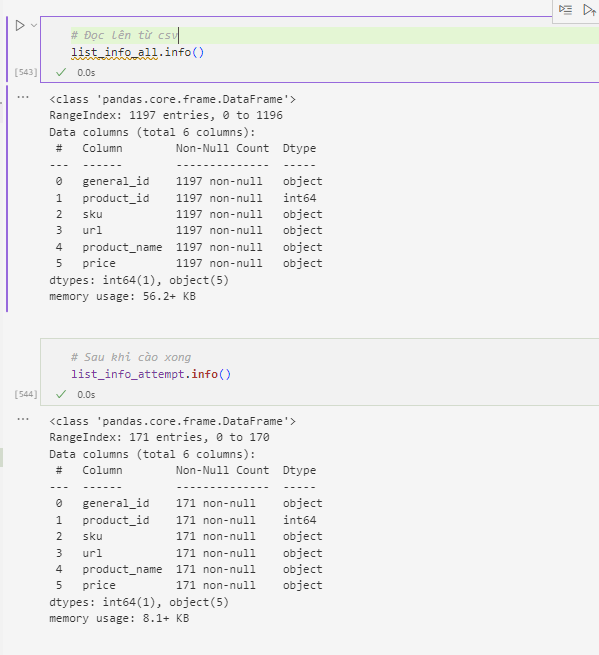

In [331]:
list_info_all_path = os.path.join(data_folder, domain, f"list_info_all.csv")

# Lưu list_info_attempt
list_info_attempt_path = save_tracking_file(attempt_folder_path, list_info_attempt, 'list_info_attempt')
list_info_attempt = pd.read_csv(list_info_attempt_path)

# LẦN ĐẦU
if not os.path.exists(list_info_all_path):    
    # Cào hết
    list_info_add = list_info_attempt
    list_info_all = list_info_attempt
    list_info_all.to_csv(list_info_all_path, index=False)
    
# CÀO LẠI
else:
    list_info_all = pd.read_csv(list_info_all_path)
    list_info_add =  create_list_info_add(list_info_attempt, list_info_all) 
    
    # Thêm vào db tổng   
    list_info_all = pd.concat([list_info_all, list_info_add], axis=0)
    list_info_all.to_csv(list_info_all_path, index=False)


print(f"Độ dài all: {len(list_info_all)}")
print(f"Độ dài attempt: {len(list_info_attempt)}")
print(f"Độ dài add: {len(list_info_add)}")


Độ dài all: 172
Độ dài attempt: 172
Độ dài add: 52


In [332]:
list_info_add_path = save_tracking_file(attempt_folder_path, list_info_add, 'list_info_add')

## Cào ảnh từ Listview, chọn ảnh cần cào từ list_info_add

In [333]:
import ast

## Tạo folder list view
list_view_folder = os.path.join(attempt_folder_path, 'list view')

img_dict = {}

for index, row in list_info_add.iterrows():
    image_dict = row['image_list']
    image_dict = ast.literal_eval(image_dict)
    img_dict.update(image_dict)

## Cào ảnh từ list
save_images(img_dict = img_dict, 
            folder_path = list_view_folder)

## Scan các Detailview đã cào của lần cào này
**Đối chiếu với list_info_add.csv để lọc detail view cần cào bổ sung**

Lần cào này đang cào detail thì lỗi --> cào lại tại đây
### Cào

In [334]:
ids_to_crawl_detail = get_ids_to_crawl_detail(attempt_folder_path=attempt_folder_path)
items_to_crawl = list_info_add[list_info_add['general_id'].isin(ids_to_crawl_detail)]

# Cào
crawl_json_images_html(items_to_crawl)
print(f'Số file detail cần cào thêm cho lần cào này là {len(ids_to_crawl_detail)}')

Progress: 100.00%
Số file detail cần cào thêm cho lần cào này là 52


# Gộp detail_info_attempt

In [335]:
detail_info_attempt, detail_info_attempt_path = create_detail_info_attempt(attempt_folder_path)
if detail_info_attempt is None or detail_info_attempt.empty:
    print('Lần này detail_info_attempt không có detail nào.')
else:
    print(detail_info_attempt_path)
    print(f"Số dòng detail_info_attempt {len(detail_info_attempt)}")

E:\COLLEGE\PROJECT\Thay Nhan\INTERN\Crawling\data\elise\2024\3\5\attempt_at_0921\detail_info_attempt.csv
Số dòng detail_info_attempt 224


# Tạo list_info_done

In [336]:
list_info_done, list_info_done_path = create_list_info_done(attempt_folder_path)
if list_info_done is None or list_info_done.empty:
    print('Lần này list_info_done không có detail nào.')
else:
    print(list_info_done_path)
    print(f"Số dòng list_info_done {len(list_info_done)}")

E:\COLLEGE\PROJECT\Thay Nhan\INTERN\Crawling\data\elise\2024\3\5\attempt_at_0921\list_info_done.csv
Số dòng list_info_done 52
